<a href="https://githubtocolab.com/borislevant/python4ml/blob/main/pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Unsupervised learning: PCA

In this session we will discuss PCA: the unsipervised method for the dimentionality reduction. We use the PCA in the following cases:
1. Transfer the data into new orthogonal coordinates, while each subsequent coordinate represent the largest amount of information contatined in the data
2. Project the high-dimensional data onto 2D space, which can be visualized
3. Choose small number of dimensions of the data in order to build more accurate machine-learning models


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import numpy as np
import seaborn as sns
import pandas as pd
from ipywidgets import interact
import scipy.stats

from sklearn.datasets import load_digits, load_iris, fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


# Find the new coordinates of the data
## Example: synthetic data

We start with a simple example using some mock data `X`.

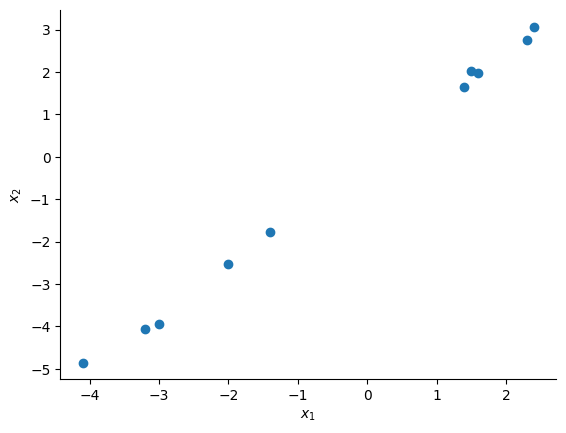

In [3]:
X = np.array([
    [1.4, 1.65],
    [1.6, 1.975],
    [-1.4, -1.775],
    [-2, -2.525],
    [-3, -3.95],
    [2.4, 3.075],
    [1.5, 2.025],
    [2.3, 2.75],
    [-3.2, -4.05],
    [-4.1, -4.85]
])
n = X.shape[0]

plt.plot(X[:,0], X[:,1], 'o')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
sns.despine()

The goal is to transform these two highly correlated variables, $x_1$ and $x_2$, into one variable that has most of the information in $x_1$ and $x_2$.

Our objective is to transform the data, using only rotation and reflections (or in general, orthogonal transformations), so that the transformed x-axes, called the first principle component, will account for as much of the variability in the data as possible.

Note: PCA is normally applied to multidimensional data, but the idea is the same: each subsequent principal component should account for as much unexplained variability as possible.

We use Scikit-learn's `PCA` model. The `fit_transform` will both find the set of transformations and apply them to the data, producing the transofrmed data `X_`.

The plot shows the original data in blue and the transformed data in orange, with arrows pointing from original to transformed.

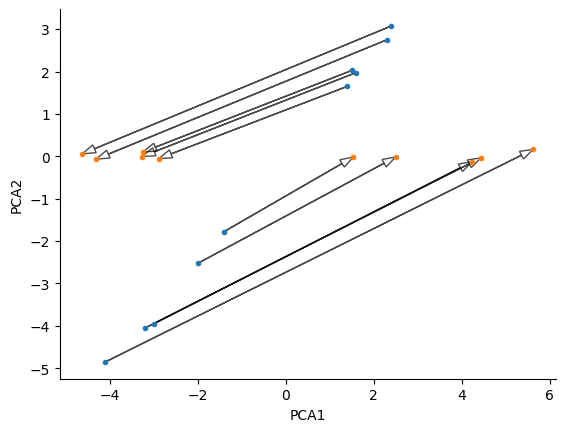

In [6]:
X_ = PCA(n_components=2).fit_transform(X)

plt.plot(X[:,0], X[:,1], '.')
plt.plot(X_[:,0], X_[:,1], '.')

for j in range(X.shape[0]):
    x1, x2, x1_, x2_ = X[j,0], X[j,1], X_[j,0], X_[j,1]
    dx1, dx2 = x1_ - x1, x2_ - x2
    plt.arrow(x1, x2, dx1, dx2, head_width=0.2, length_includes_head=True, fc='none', alpha=0.7)
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    
sns.despine()

# Technical details

Our data matrix $X$ of shape $n$-by-$m$, is composed of a column of length $n$ for each feature $x_1, x_2, \ldots, x_m$.

We assume that the features are already normalized, that is, that $E[x_k] = 0$ for all $k$; otherwise, we redefine $x_k \leftarrow x_k - E[x_k]$. 

We are looking for a projection matrix $A$ in which each colum is a vector defining the direction of one of the new axes, and these columns must be orthogonal (and even orthonormal, $A^T A = I$). 

Then $A$ is an $m$-by-$m$ matrix, with columns $a_1, \ldots, a_m$.

The data after the project is $\tilde X$:
$$
\tilde X = X \cdot A^T
$$

The first projected column $\tilde  x_1$, or feature, is called the first **principal component** and denoted PC1. It is defined by
$$
\tilde x_1 = X \cdot a_1
$$
and we want to find $a_1$ that maximized $Var[\tilde x_1]$ subject to the constraint $a_1^T a_1=1$.

By definition of variance,

$$
Var[\tilde x_1] = E[\tilde x_1 ^2] - E[\tilde x_1]^2
$$

To proceed, note that for $E[\tilde x_1] = E[X \cdot a_1] = 0$ becuase we assumed $E[x_k]=0$ for all $k$, so (all expectations are over the data samples):

$$
Var[\tilde x_1] = 
E[\tilde x_1 ^2] = \\ 
E[(X \cdot a_1)^2] = E[X \cdot a_1 \cdot X \cdot a_1] = \\
E[(X \cdot a_1)^2] = E[X \cdot a_1 \cdot X \cdot a_1] = a_1 E[X^T X] a_1 ^T = \\
a_1 S a_1 ^T
$$
where $S=E[X^T X]$ is the covariance matrix of $X$.

Then, we are looking for $a_1$ that maximizes $a_1 S a_1 ^T$ with the constraint $a_1 ^T a_1 = 1$.

This is an optimization problem that can be solved using the method of Lagrange multipliers.
That is, we are looking for $a_1, \lambda$ that maximize the expression
$$
L(a_1, \lambda) = a_1 S a_1 ^T - \lambda (a_1 a_1^T - 1)
$$
To find the max, we take the derivative with respect to $a_1$ and set it to zero:
$$
\frac{\partial L}{a_1} = 2 a_1 S - 2 \lambda a_1 = 0 \Rightarrow \\
a_1 S = \lambda a_1
$$
So, $\lambda$ is an eigenvalue of $S$ and $a_1$ is its corresponding eigenvector.

Moreover, we get:
$$
Var[\tilde x_1] = a_1 S a_1^T = \lambda a_1 a_1 ^T = \lambda
$$
So the eigenvalue of $S$ equals the variance of $\tilde x_1$.

This process holds for all $\tilde x_k$.

Therefore, the eigenvalues of $S$ are the variances of the projected data, or the new features, and the eigenvectors of $S$ are new projection axes.

# Projecting the high-dimensional data onto 2D
# Example: Iris dataset

We now proceed to an intermediate number of dimensions: the Iris dataset that we have encountered in the machine learning session.

In [14]:
df = pd.read_csv('data/iris_dataset.csv')
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [16]:
X = scale(df[features].values) # scaling is important for PCA (like most linear models)
y = df['species'].values
encoder = LabelEncoder()
y = encoder.fit_transform(y)

colors = sns.color_palette('Set1', 3)
cmap = [colors[y_] for y_ in y]

Since the Iris dataset is labeled (targets are included), we can use it to demonstrate the potential of PCA for classification.

Start by plotting the original dataset, but only with the petal length and petal width, which we already determined are the best two variables to use for k-nearest neighbors.

We use text plotting to plot the short name of each Iris label.

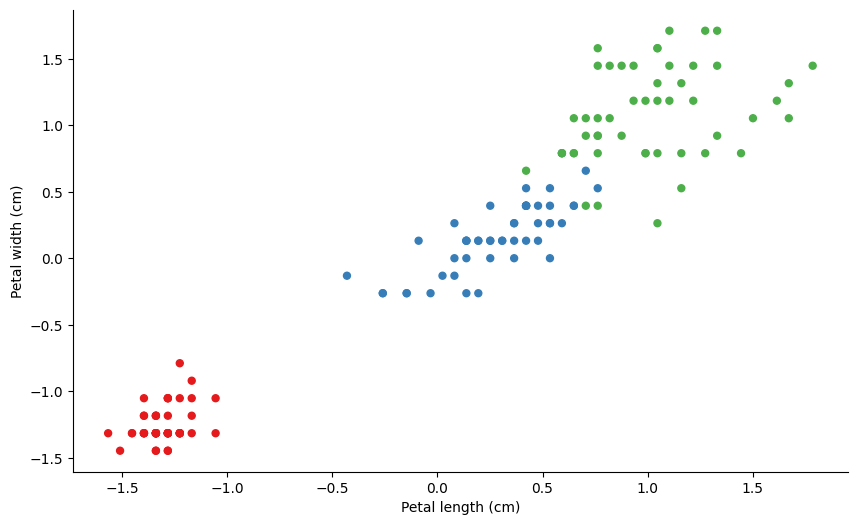

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X[:, 2], X[:, 3], c=cmap, s=25)
ax.set_xlabel('Petal length (cm)')
ax.set_ylabel('Petal width (cm)');
sns.despine()

Now we use PCA to transform the entire Iris dataset to a 2D space.

Note: the use of `scale` on the data to make sure that all variables have the same scale.

In [18]:
X_ = PCA(n_components=2).fit_transform(X)

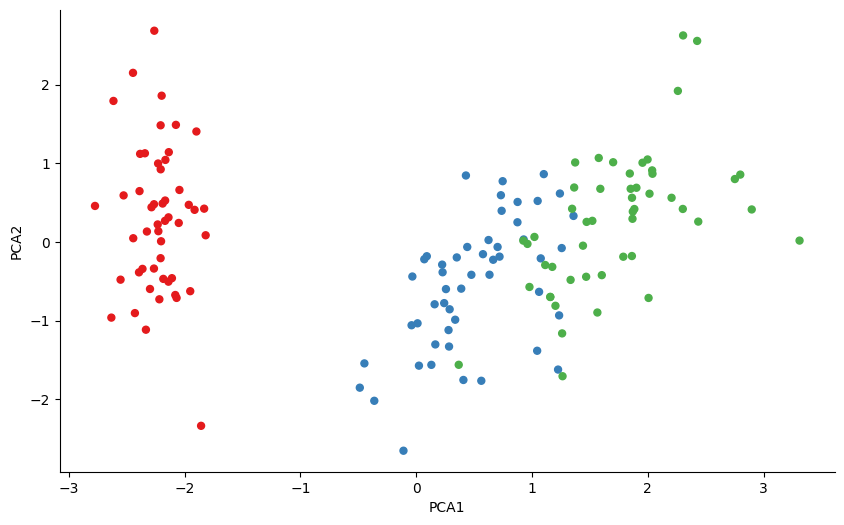

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X_[:, 0], X_[:, 1], c=cmap, s=25)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
sns.despine()

## Example: Digits dataset

Now we load the digits dataset. This is a dataset of handwritten digits saved as 8-by-8 images.
The images are made of 64 pixel values between 0 and 16 -- this is a high-dimensional problem.

`@interact` is a special decorator that creates an interactive widgets; refer to [ipywidgets docs](ipywidgets.readthedocs.io) for setup instructions.

In [77]:
X = np.load('./data/mnist_small_data.npy')
y = np.load('./data/mnist_small_labels.npy')
X.shape, y.shape

((1797, 64), (5000, 1))

In [78]:
n_samples, n_features = X.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

def plot_digit(im, ax=None):
    if ax is None: fig, ax = plt.subplots()
    ax.imshow(im, norm=BoundaryNorm(np.unique(X), 255), cmap='gray_r')
    ax.set(xticks=[], yticks=[])
    
# conda install ipywidgets
@interact(index=(0, digits.data.shape[0], 1))
def explore_digits(index=0):
    im = X[index].reshape((8, 8))
    plot_digit(im)
    print("Digit:", labels[index])

interactive(children=(IntSlider(value=0, description='index', max=1797), Output()), _dom_classes=('widget-inte…

**Use PCA to project the dataset to a 2D space and plot the digits.**

Use a different color for each digit (i.e. label) and possibly plot using text digits.

The plot will show us what digits are "close" to each other, which should reflect some measure of similarity.

Does it make sense? Did you expect 0 to be close to 9 and 6? 4 close to 6? 7 and 1?


In [79]:
pca = PCA()
X_ = pca.fit_transform(X)

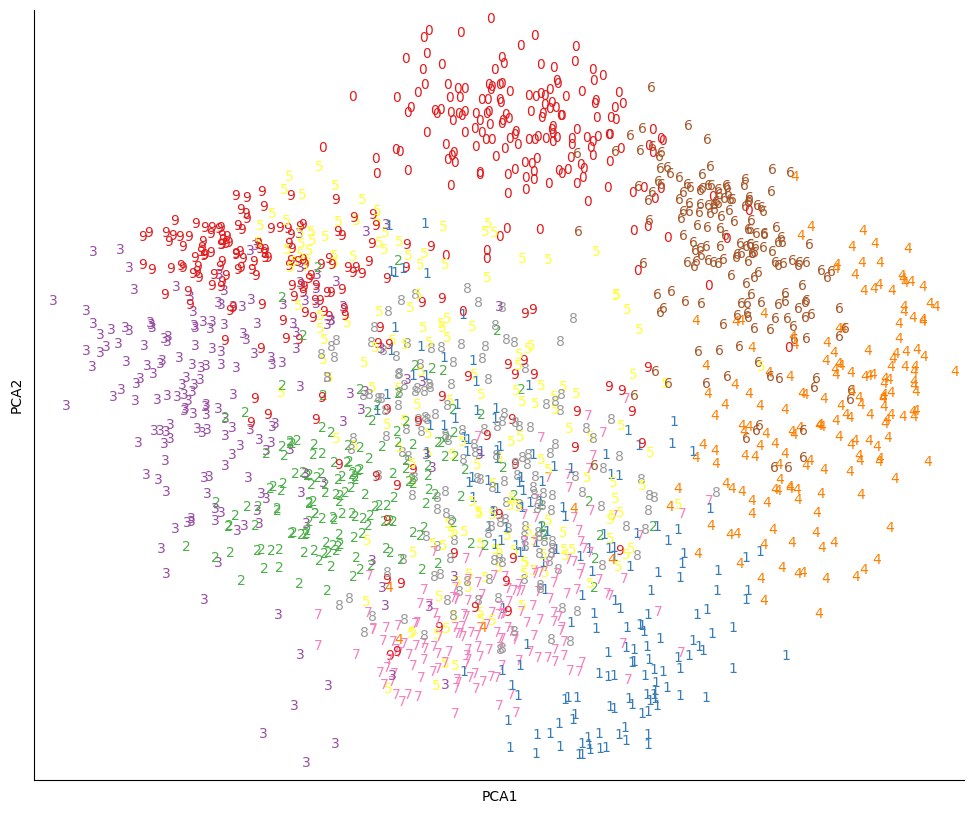

In [80]:
colors = sns.color_palette('Set1', 10)

PC1 = X_[:, 0]
PC2 = X_[:, 1]

fig, ax = plt.subplots(figsize=(12, 10))
for pc1, pc2, s in zip(PC1, PC2, labels):
    c = colors[s]
    ax.text(pc1, pc2, str(s), fontdict=dict(fontsize=10, color=c))
ax.set_xlim(PC1.min()-1, PC1.max()+1)
ax.set_ylim(PC2.min()-1, PC2.max()+1)
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
sns.despine()

In high-dimensional cases it is interesting to see the % of variance explained by each principal component.
In this case we can see that the first 3-4 components explain 40%-50% of the variance.

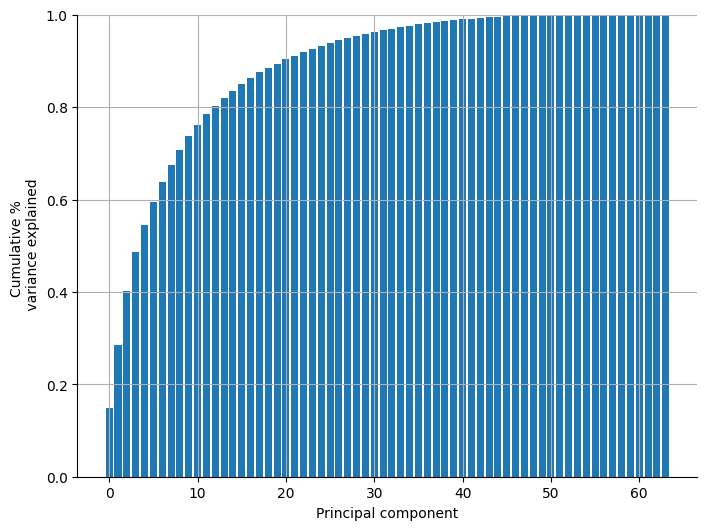

In [81]:
var = pca.explained_variance_ratio_
cumvar = np.cumsum(var)

plt.figure(figsize=(8, 6))
plt.grid(True)
plt.bar(range(n_features), cumvar)
plt.xlabel('Principal component')
plt.ylabel('Cumulative % \n variance explained')
plt.ylim(0, 1)
sns.despine()

# Training a better ML models
## Example: face images

We now load the Olivetti face dataset.

In [82]:
def plot_face(img, ax=None):
    if ax is None: fig, ax = plt.subplots()
    ax.imshow(img.reshape(img_shape), cmap='bone')
    ax.set(xticks=[], yticks=[])
    return ax

X = np.load("./data/olivetti_faces.npy").reshape(-1, 64*64)
y = np.load("./data/olivetti_faces_target.npy")
img_shape = 64, 64

The dataset contains images of several persons - we will display the first 8 persons.

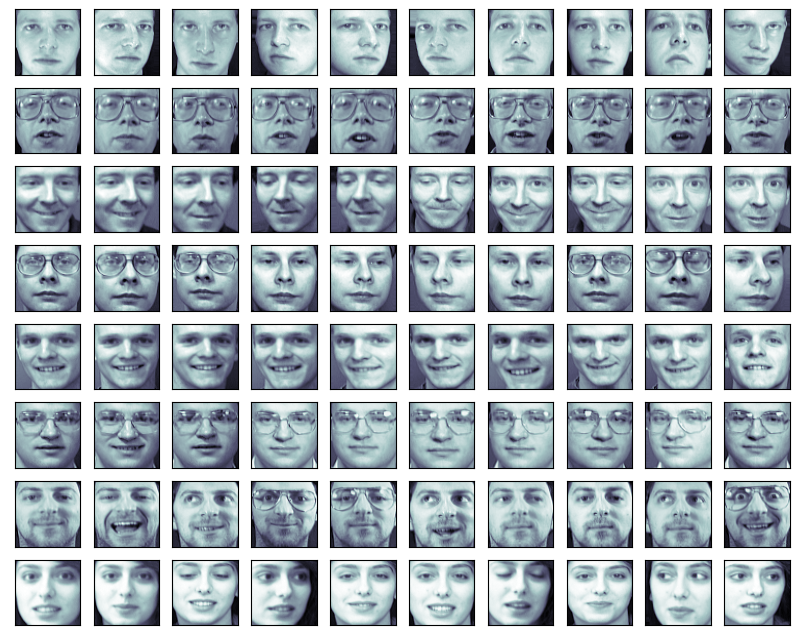

In [83]:
fig, axes = plt.subplots(8, 10, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    plot_face(X[i], ax=ax)    

Lets also look at the mean face, as PCA will arrange the images around their mean.

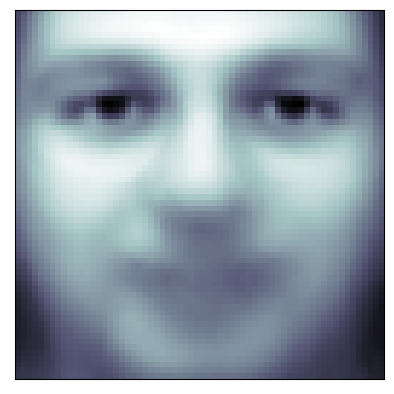

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
plot_face(X_train.mean(axis=0));

Now lets apply PCA to the images.

Note that we will do a train test split to see how this analysis works for unseen (test) data.

In [85]:
pca = PCA(whiten=True)
pca.fit(X_train)

PCA(whiten=True)

We can plot the cumulative explained variance ratio. It is interesting that 5 dimensions are enough for > 50%.

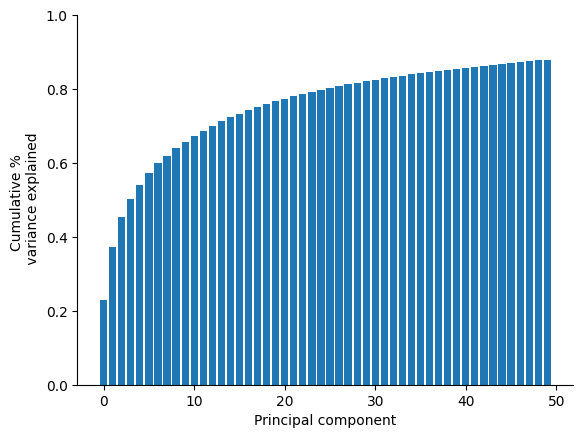

In [86]:
var = pca.explained_variance_ratio_
cumvar = np.cumsum(var)

plt.bar(range(50), cumvar[:50])
plt.xlabel('Principal component')
plt.ylabel('Cumulative % \n variance explained')
plt.ylim(0, 1)
sns.despine()

Now lets visualize the principle components -- these are also called _eigenfaces_.
Each of the 50 components maps the pixels of the images into its dimension, similar to coefficients in a linear model. Indeed, PCA is a linear model to a smaller space.

We will look at the first 20 components.

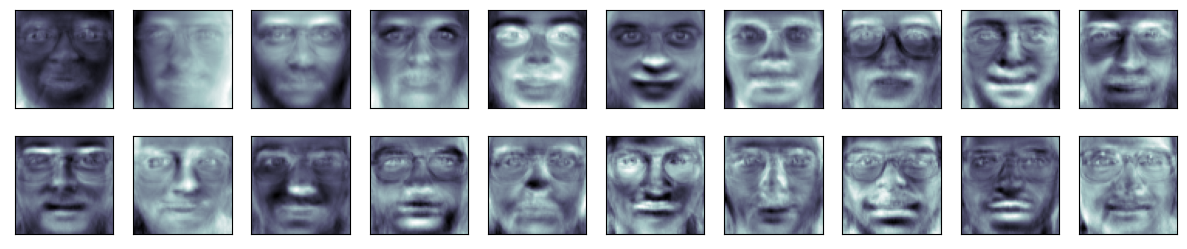

In [87]:
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    plot_face(pca.components_[i,:], ax=ax)
    ax.set(xticks=[], yticks=[])

It appears that the first components are about lighting (from the front, from the right), and the next ones are about facial features: eye-brows, eyes, nose, glasses, mouth.

We can transform a face, change one of the PCs, then transform it back to a face and see the result.

Note: PC values are between -2 and 2.

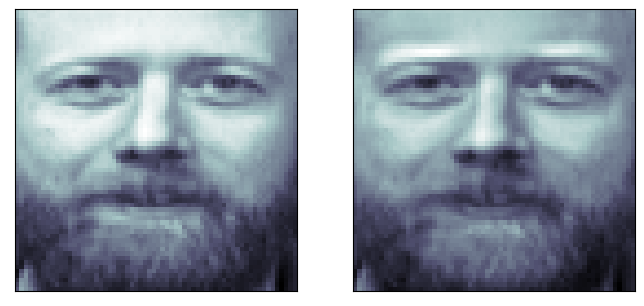

In [88]:
pc = 10
value = 3

fig, axes = plt.subplots(1, 2, figsize=(8,4))
face = X_train[0]
plot_face(face, ax=axes[0]);
face_pca = pca.transform(face.reshape((1, -1)))
face_pca[0, pc] = value # THIS IS THE ACTION
face_inverse = pca.inverse_transform(face_pca)
plot_face(face_inverse, ax=axes[1]);

Next, we can use the PCs for classification, instead of directly using the images. The rationale is that PCA has already found "meaningful" features for use with a classifier.

For this is would be useful to use just the first 50 components, as most of the variation is already included in these components.

In [89]:
pca = PCA(n_components=50, whiten=True)
pca.fit(X_train)

classifier_faces =  KNeighborsClassifier()
classifier_pca = KNeighborsClassifier()

classifier_faces.fit(X_train, y_train)
classifier_pca.fit(pca.transform(X_train), y_train)

print("Accuracy without PCA:\t", classifier_faces.score(X_test, y_test))
print("Accuracy with PCA:\t",classifier_pca.score(pca.transform(X_test), y_test))

Accuracy without PCA:	 0.76
Accuracy with PCA:	 0.8


When using two models sequentially, we can setup a Scikit-learn _Pipeline_.

Then, we don't need to call `transform` every time we want to use the classifier.

In [90]:
classifier = Pipeline([
    ('pca', PCA(n_components=50, whiten=True)),
    ('knn', KNeighborsClassifier())
])
classifier.fit(X_train, y_train)
print("Accuracy:\t", classifier.score(X_test, y_test))

Accuracy:	 0.85


# Refernces

- Jon Shlens' [PCA tutorial](https://www.cs.princeton.edu/picasso/mats/PCA-Tutorial-Intuition_jp.pdf)
- [t-SNE paper](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf)
- [PCA tutorial published in Nature](https://www.nature.com/articles/nmeth.4346.pdf)
- [Eigenfaces tutorial on Scikit-learn](https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html)